# Transfer Learning - resnet50 with SGD optimizer

- This notebook explores transfer learning using the resnet50 model with SGD optimizer, where the feature extraction layers are kept frozen using the default weights and only the classifier is changed and retrained.

In [1]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

# Add project root to sys.path if it does not exist
project_root = Path().resolve().parents[0]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.data.custom_dataset import CustomDataset
from utils.utils import create_logger

In [2]:
model_variant = "resnet50_sgd"
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [3]:
logging_config_path = project_root / "conf" / "logger_conf.yml"
logs_dir = project_root / "logs"
logs_dir.mkdir(parents=True, exist_ok=True)
log_filename = project_root / "logs" / f"trnfl_{model_variant}_{timestamp}.log"

In [4]:
# Initialize logger
logger = create_logger(str(logging_config_path), str(log_filename))

In [5]:
# Log to confirm setup
logger.info(f"Logging initialized. Log file: {log_filename}")

[02/03/25 16:31:44] INFO     INFO - Logging initialized. Log file:                                   ]8;id=109838;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/693054657.py\693054657.py]8;;\:]8;id=933498;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/693054657.py#2\2]8;;\
                             /Users/jas/Documents/car-classification-api/logs/trnfl_resnet50_sgd_03-               
                             02-2025-16-31.log                                                                     

In [6]:
# Define augmentations to be carried out
train_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # transforms.RandomAffine(degrees=(20, 70), translate=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
train_dir = project_root / "data" / "train"

In [8]:
# Load the train dataset
train_data = ImageFolder(root=str(train_dir))

# Extract labels
labels = [train_data.targets[idx] for idx in range(len(train_data))]

# Get class mapping
class_mapping = {idx: class_name for idx, class_name in enumerate(train_data.classes)}

In [9]:
# Stratified split into train and val sets
train_indices, val_indices = train_test_split(
    range(len(train_data)), 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

In [10]:
# Define train and validation datasets with separate transforms
train_dataset = CustomDataset(train_data, train_indices, transform=train_transformers)
val_dataset = CustomDataset(train_data, val_indices, transform=val_transformers)

In [11]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
# Load pre-trained model, ResNet
model = models.resnet50(weights='DEFAULT')

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Modify final layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(train_data.classes))

In [15]:
logger.info(model)

[02/03/25 16:31:45] INFO     INFO - ResNet(                                                         ]8;id=872247;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/1427801074.py\1427801074.py]8;;\:]8;id=295609;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/1427801074.py#1\1]8;;\
                               (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2),                           
                             padding=(3, 3), bias=False)                                                           
                               (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,                        
                             track_running_stats=True)                                                             
                               (relu): ReLU(inplace=True)                                                          
                               (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1,                
                             ceil_mode=False)                                                                      
                               (layer1): Sequential(                                                               
                                 (0): Bottleneck(                                                                  
                                   (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1),                      
                             bias=False)                                                                           
                                   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,                    
                             track_running_stats=True)                                                             
                                   (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),                      
                             padding=(1, 1), bias=False)                                                           
                                   (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,                    
                             track_running_stats=True)                                                             
                                   (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),                     
                             bias=False)                                                                           
                                   (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,                   
                             track_running_stats=True)                                                             
                                   (relu): ReLU(inplace=True)                                                      
                                   (downsample): Sequential(                                                       
                                     (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),                       
                             bias=False)                                                                           
                                     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,                   
                             track_running_stats=True)                                                             
                                   )                                                                               
                                 )                                                                                 
                                 (1): Bottleneck(                                                                  
                                   (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1),                     
                             bias=False)                                

In [16]:
len(train_data.classes)

196

In [17]:
# Freeze all layers except the final fully connected layer
for name, param in model.named_parameters():
    if not name.startswith("fc"):  # Freeze everything except the final layer
        param.requires_grad = False

In [18]:
# Check for MPS support (for Mac GPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS (Metal Performance Shaders)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Fallback to CUDA or CPU

# Move model to the selected device
model = model.to(device)
logger.info(f"Using device: {device}")

                    INFO     INFO - Using device: mps                                               ]8;id=363213;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/2176772055.py\2176772055.py]8;;\:]8;id=801255;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/2176772055.py#9\9]8;;\

In [19]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Training loop + eval on val
epochs = 20

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')

for epoch in range(epochs):
    # Training 
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Predictions for training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # Val
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Predictions for val accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print metrics 
    logger.info(f"Epoch {epoch+1}/{epochs}")
    logger.info(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Correct Predictions: {correct_train}/{total_train}")
    logger.info(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Correct Predictions: {correct_val}/{total_val}")

[02/03/25 16:34:20] INFO     INFO - Epoch 1/20                                                      ]8;id=567177;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=946116;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 5.2659, Train Accuracy: 0.98%, Correct Predictions: ]8;id=341933;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=108080;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             64/6515                                                                               

                    INFO     INFO - Val Loss: 5.2236, Val Accuracy: 1.35%, Correct Predictions:     ]8;id=277193;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=182564;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             22/1629                                                                               

[02/03/25 16:37:25] INFO     INFO - Epoch 2/20                                                      ]8;id=351529;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=822654;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 5.2060, Train Accuracy: 2.12%, Correct Predictions: ]8;id=262608;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=185219;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             138/6515                                                                              

                    INFO     INFO - Val Loss: 5.1703, Val Accuracy: 2.39%, Correct Predictions:     ]8;id=772936;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=22875;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             39/1629                                                                               

[02/03/25 16:40:31] INFO     INFO - Epoch 3/20                                                      ]8;id=149920;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=217125;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 5.1515, Train Accuracy: 3.84%, Correct Predictions: ]8;id=205960;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=307352;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             250/6515                                                                              

                    INFO     INFO - Val Loss: 5.1219, Val Accuracy: 3.07%, Correct Predictions:     ]8;id=822908;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=178067;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             50/1629                                                                               

[02/03/25 16:43:36] INFO     INFO - Epoch 4/20                                                      ]8;id=594276;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=472130;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 5.0976, Train Accuracy: 5.51%, Correct Predictions: ]8;id=354914;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=209533;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             359/6515                                                                              

                    INFO     INFO - Val Loss: 5.0727, Val Accuracy: 4.48%, Correct Predictions:     ]8;id=497246;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=375533;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             73/1629                                                                               

[02/03/25 16:46:45] INFO     INFO - Epoch 5/20                                                      ]8;id=262594;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=547015;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 5.0444, Train Accuracy: 7.95%, Correct Predictions: ]8;id=993542;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=588325;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             518/6515                                                                              

                    INFO     INFO - Val Loss: 5.0219, Val Accuracy: 5.52%, Correct Predictions:     ]8;id=639434;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=387045;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             90/1629                                                                               

[02/03/25 16:49:56] INFO     INFO - Epoch 6/20                                                      ]8;id=790423;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=127722;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.9934, Train Accuracy: 9.56%, Correct Predictions: ]8;id=741634;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=371197;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             623/6515                                                                              

                    INFO     INFO - Val Loss: 4.9828, Val Accuracy: 6.88%, Correct Predictions:     ]8;id=409864;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=975873;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             112/1629                                                                              

[02/03/25 16:53:08] INFO     INFO - Epoch 7/20                                                      ]8;id=893865;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=35366;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.9432, Train Accuracy: 10.67%, Correct             ]8;id=543134;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=402698;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 695/6515                                                                 

                    INFO     INFO - Val Loss: 4.9411, Val Accuracy: 7.43%, Correct Predictions:     ]8;id=930995;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=895154;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             121/1629                                                                              

[02/03/25 16:56:22] INFO     INFO - Epoch 8/20                                                      ]8;id=870363;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=771031;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.8940, Train Accuracy: 12.66%, Correct             ]8;id=771692;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=259224;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 825/6515                                                                 

                    INFO     INFO - Val Loss: 4.8919, Val Accuracy: 9.15%, Correct Predictions:     ]8;id=840175;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=103036;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             149/1629                                                                              

[02/03/25 16:59:33] INFO     INFO - Epoch 9/20                                                      ]8;id=873565;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=830031;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.8485, Train Accuracy: 14.63%, Correct             ]8;id=38149;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=839073;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 953/6515                                                                 

                    INFO     INFO - Val Loss: 4.8533, Val Accuracy: 9.76%, Correct Predictions:     ]8;id=396530;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=678366;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             159/1629                                                                              

[02/03/25 17:02:51] INFO     INFO - Epoch 10/20                                                     ]8;id=36369;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=443312;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.8008, Train Accuracy: 15.58%, Correct             ]8;id=851205;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=388155;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1015/6515                                                                

                    INFO     INFO - Val Loss: 4.8150, Val Accuracy: 10.99%, Correct Predictions:    ]8;id=317860;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=122853;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             179/1629                                                                              

[02/03/25 17:06:06] INFO     INFO - Epoch 11/20                                                     ]8;id=37309;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=28958;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.7567, Train Accuracy: 17.50%, Correct             ]8;id=3400;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=639656;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1140/6515                                                                

                    INFO     INFO - Val Loss: 4.7743, Val Accuracy: 11.48%, Correct Predictions:    ]8;id=754389;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=54223;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             187/1629                                                                              

[02/03/25 17:09:22] INFO     INFO - Epoch 12/20                                                     ]8;id=645816;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=350507;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.7129, Train Accuracy: 18.10%, Correct             ]8;id=414140;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=465902;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1179/6515                                                                

                    INFO     INFO - Val Loss: 4.7290, Val Accuracy: 11.91%, Correct Predictions:    ]8;id=785450;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=492679;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             194/1629                                                                              

[02/03/25 17:12:41] INFO     INFO - Epoch 13/20                                                     ]8;id=291171;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=198297;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.6713, Train Accuracy: 19.26%, Correct             ]8;id=496997;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=846895;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1255/6515                                                                

                    INFO     INFO - Val Loss: 4.7028, Val Accuracy: 12.89%, Correct Predictions:    ]8;id=392671;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=503183;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             210/1629                                                                              

[02/03/25 17:16:00] INFO     INFO - Epoch 14/20                                                     ]8;id=215632;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=639;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.6306, Train Accuracy: 20.61%, Correct             ]8;id=342111;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=813608;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1343/6515                                                                

                    INFO     INFO - Val Loss: 4.6692, Val Accuracy: 12.95%, Correct Predictions:    ]8;id=486417;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=32512;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             211/1629                                                                              

[02/03/25 17:19:16] INFO     INFO - Epoch 15/20                                                     ]8;id=674854;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=20001;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.5882, Train Accuracy: 21.96%, Correct             ]8;id=634191;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=112948;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1431/6515                                                                

                    INFO     INFO - Val Loss: 4.6304, Val Accuracy: 13.32%, Correct Predictions:    ]8;id=906587;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=305912;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             217/1629                                                                              

[02/03/25 17:22:33] INFO     INFO - Epoch 16/20                                                     ]8;id=23871;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=269801;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.5476, Train Accuracy: 22.84%, Correct             ]8;id=610071;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=950727;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1488/6515                                                                

                    INFO     INFO - Val Loss: 4.5997, Val Accuracy: 14.00%, Correct Predictions:    ]8;id=810459;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=215312;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             228/1629                                                                              

[02/03/25 17:25:47] INFO     INFO - Epoch 17/20                                                     ]8;id=841732;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=762122;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.5063, Train Accuracy: 23.64%, Correct             ]8;id=782767;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=562034;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1540/6515                                                                

                    INFO     INFO - Val Loss: 4.5588, Val Accuracy: 14.61%, Correct Predictions:    ]8;id=762864;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=409025;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             238/1629                                                                              

[02/03/25 17:29:00] INFO     INFO - Epoch 18/20                                                     ]8;id=598280;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=46357;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.4679, Train Accuracy: 24.48%, Correct             ]8;id=602462;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=506965;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1595/6515                                                                

                    INFO     INFO - Val Loss: 4.5333, Val Accuracy: 15.35%, Correct Predictions:    ]8;id=22214;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=520565;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             250/1629                                                                              

[02/03/25 17:32:13] INFO     INFO - Epoch 19/20                                                     ]8;id=123159;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=301426;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.4319, Train Accuracy: 25.25%, Correct             ]8;id=809554;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=788514;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1645/6515                                                                

                    INFO     INFO - Val Loss: 4.5066, Val Accuracy: 15.53%, Correct Predictions:    ]8;id=557518;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=161830;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             253/1629                                                                              

[02/03/25 17:35:28] INFO     INFO - Epoch 20/20                                                     ]8;id=659242;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=569946;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.4033, Train Accuracy: 26.14%, Correct             ]8;id=715033;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=214986;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#68\68]8;;\
                             Predictions: 1703/6515                                                                

                    INFO     INFO - Val Loss: 4.4806, Val Accuracy: 16.21%, Correct Predictions:    ]8;id=258722;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py\536757366.py]8;;\:]8;id=342393;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/536757366.py#69\69]8;;\
                             264/1629                                                                              

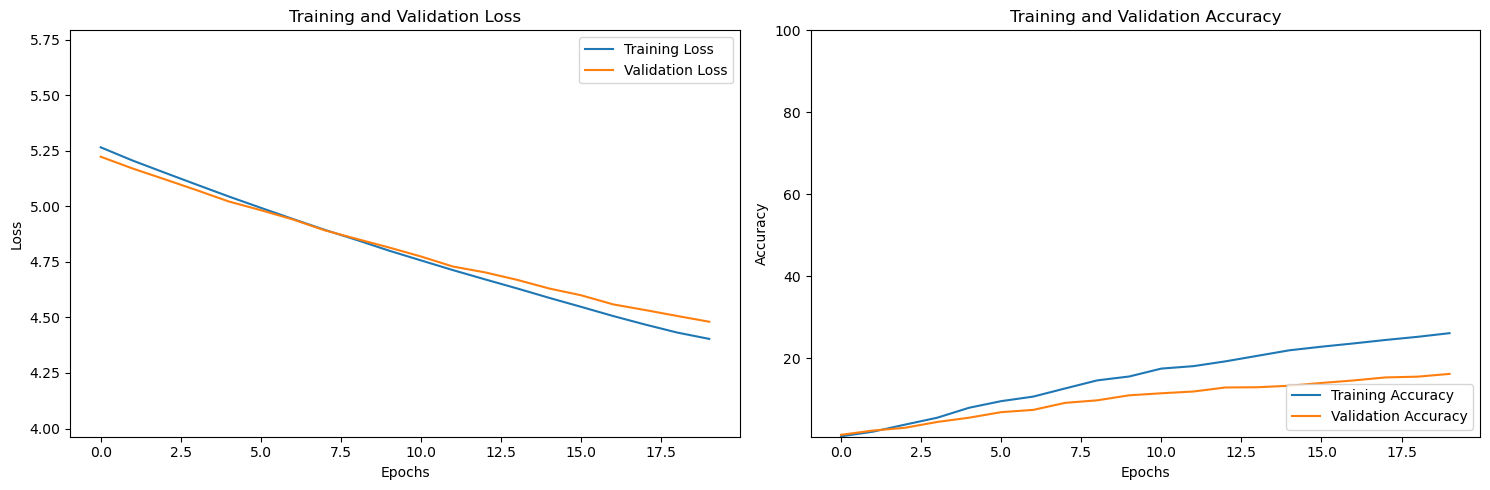

In [20]:
plt.figure(figsize=(15, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([min(min(train_losses), min(val_losses)) * 0.9, max(max(train_losses), max(val_losses)) * 1.1])
plt.title('Training and Validation Loss')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([min(min(train_accuracies), min(val_accuracies)) * 0.9, 100])
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [21]:
test_dir = project_root / "data" / "test"

In [22]:
# Load the test dataset
test_data = ImageFolder(str(test_dir), transform=test_transformers)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [23]:
y_true, y_pred = [], []

model.eval()
correct = 0
total = 0
test_loss = 0.0
processed_images = 0

# Criterion has been defined above

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        processed_images += labels.size(0)
        if processed_images % 500 == 0 or processed_images == total:
            print(f"Processed {processed_images} / {len(test_loader.dataset)} images...")

# Calculate metrics
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

logger.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=test_data.classes, columns=test_data.classes)

# Compute classification report
cr = classification_report(y_true, y_pred, target_names=test_data.classes)

Processed 32 / 8041 images...
Processed 64 / 8041 images...
Processed 96 / 8041 images...
Processed 128 / 8041 images...
Processed 160 / 8041 images...
Processed 192 / 8041 images...
Processed 224 / 8041 images...
Processed 256 / 8041 images...
Processed 288 / 8041 images...
Processed 320 / 8041 images...
Processed 352 / 8041 images...
Processed 384 / 8041 images...
Processed 416 / 8041 images...
Processed 448 / 8041 images...
Processed 480 / 8041 images...
Processed 512 / 8041 images...
Processed 544 / 8041 images...
Processed 576 / 8041 images...
Processed 608 / 8041 images...
Processed 640 / 8041 images...
Processed 672 / 8041 images...
Processed 704 / 8041 images...
Processed 736 / 8041 images...
Processed 768 / 8041 images...
Processed 800 / 8041 images...
Processed 832 / 8041 images...
Processed 864 / 8041 images...
Processed 896 / 8041 images...
Processed 928 / 8041 images...
Processed 960 / 8041 images...
Processed 992 / 8041 images...
Processed 1024 / 8041 images...
Processed 

[02/03/25 17:38:22] INFO     INFO - Test Loss: 4.4848, Test Accuracy: 15.52%                        ]8;id=655665;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/334671154.py\334671154.py]8;;\:]8;id=504372;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/334671154.py#35\35]8;;\

/Users/jas/anaconda3/envs/car-classification/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jas/anaconda3/envs/car-classification/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jas/anaconda3/envs/car-classification/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

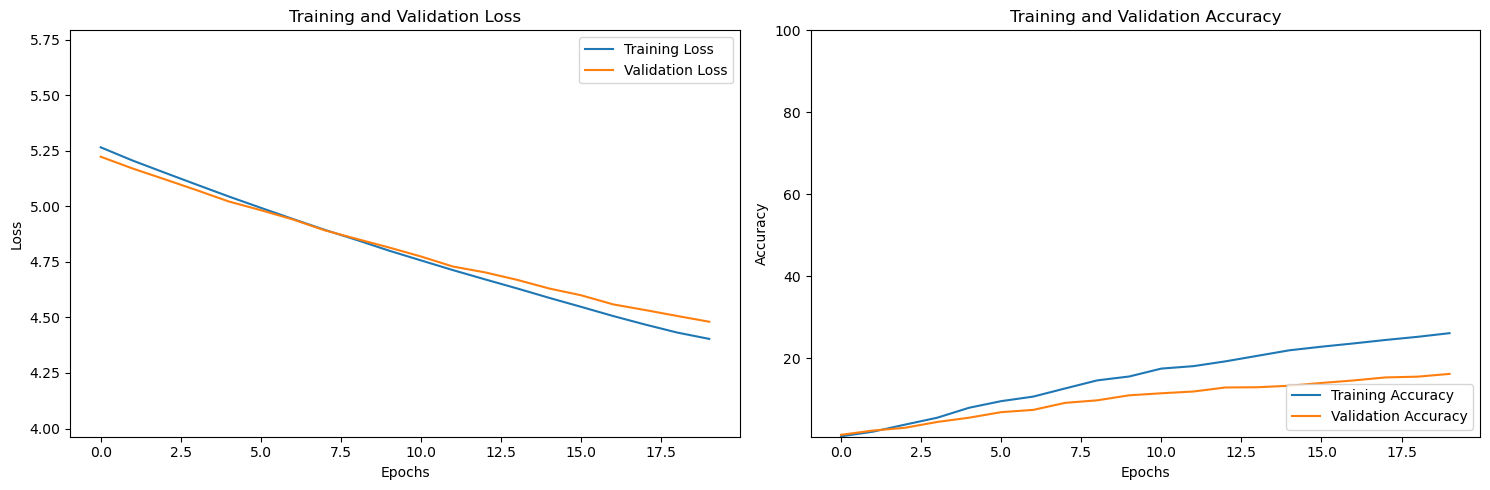

In [24]:
plt.figure(figsize=(15, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([min(min(train_losses), min(val_losses)) * 0.9, max(max(train_losses), max(val_losses)) * 1.1])
plt.title('Training and Validation Loss')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([min(min(train_accuracies), min(val_accuracies)) * 0.9, 100])
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

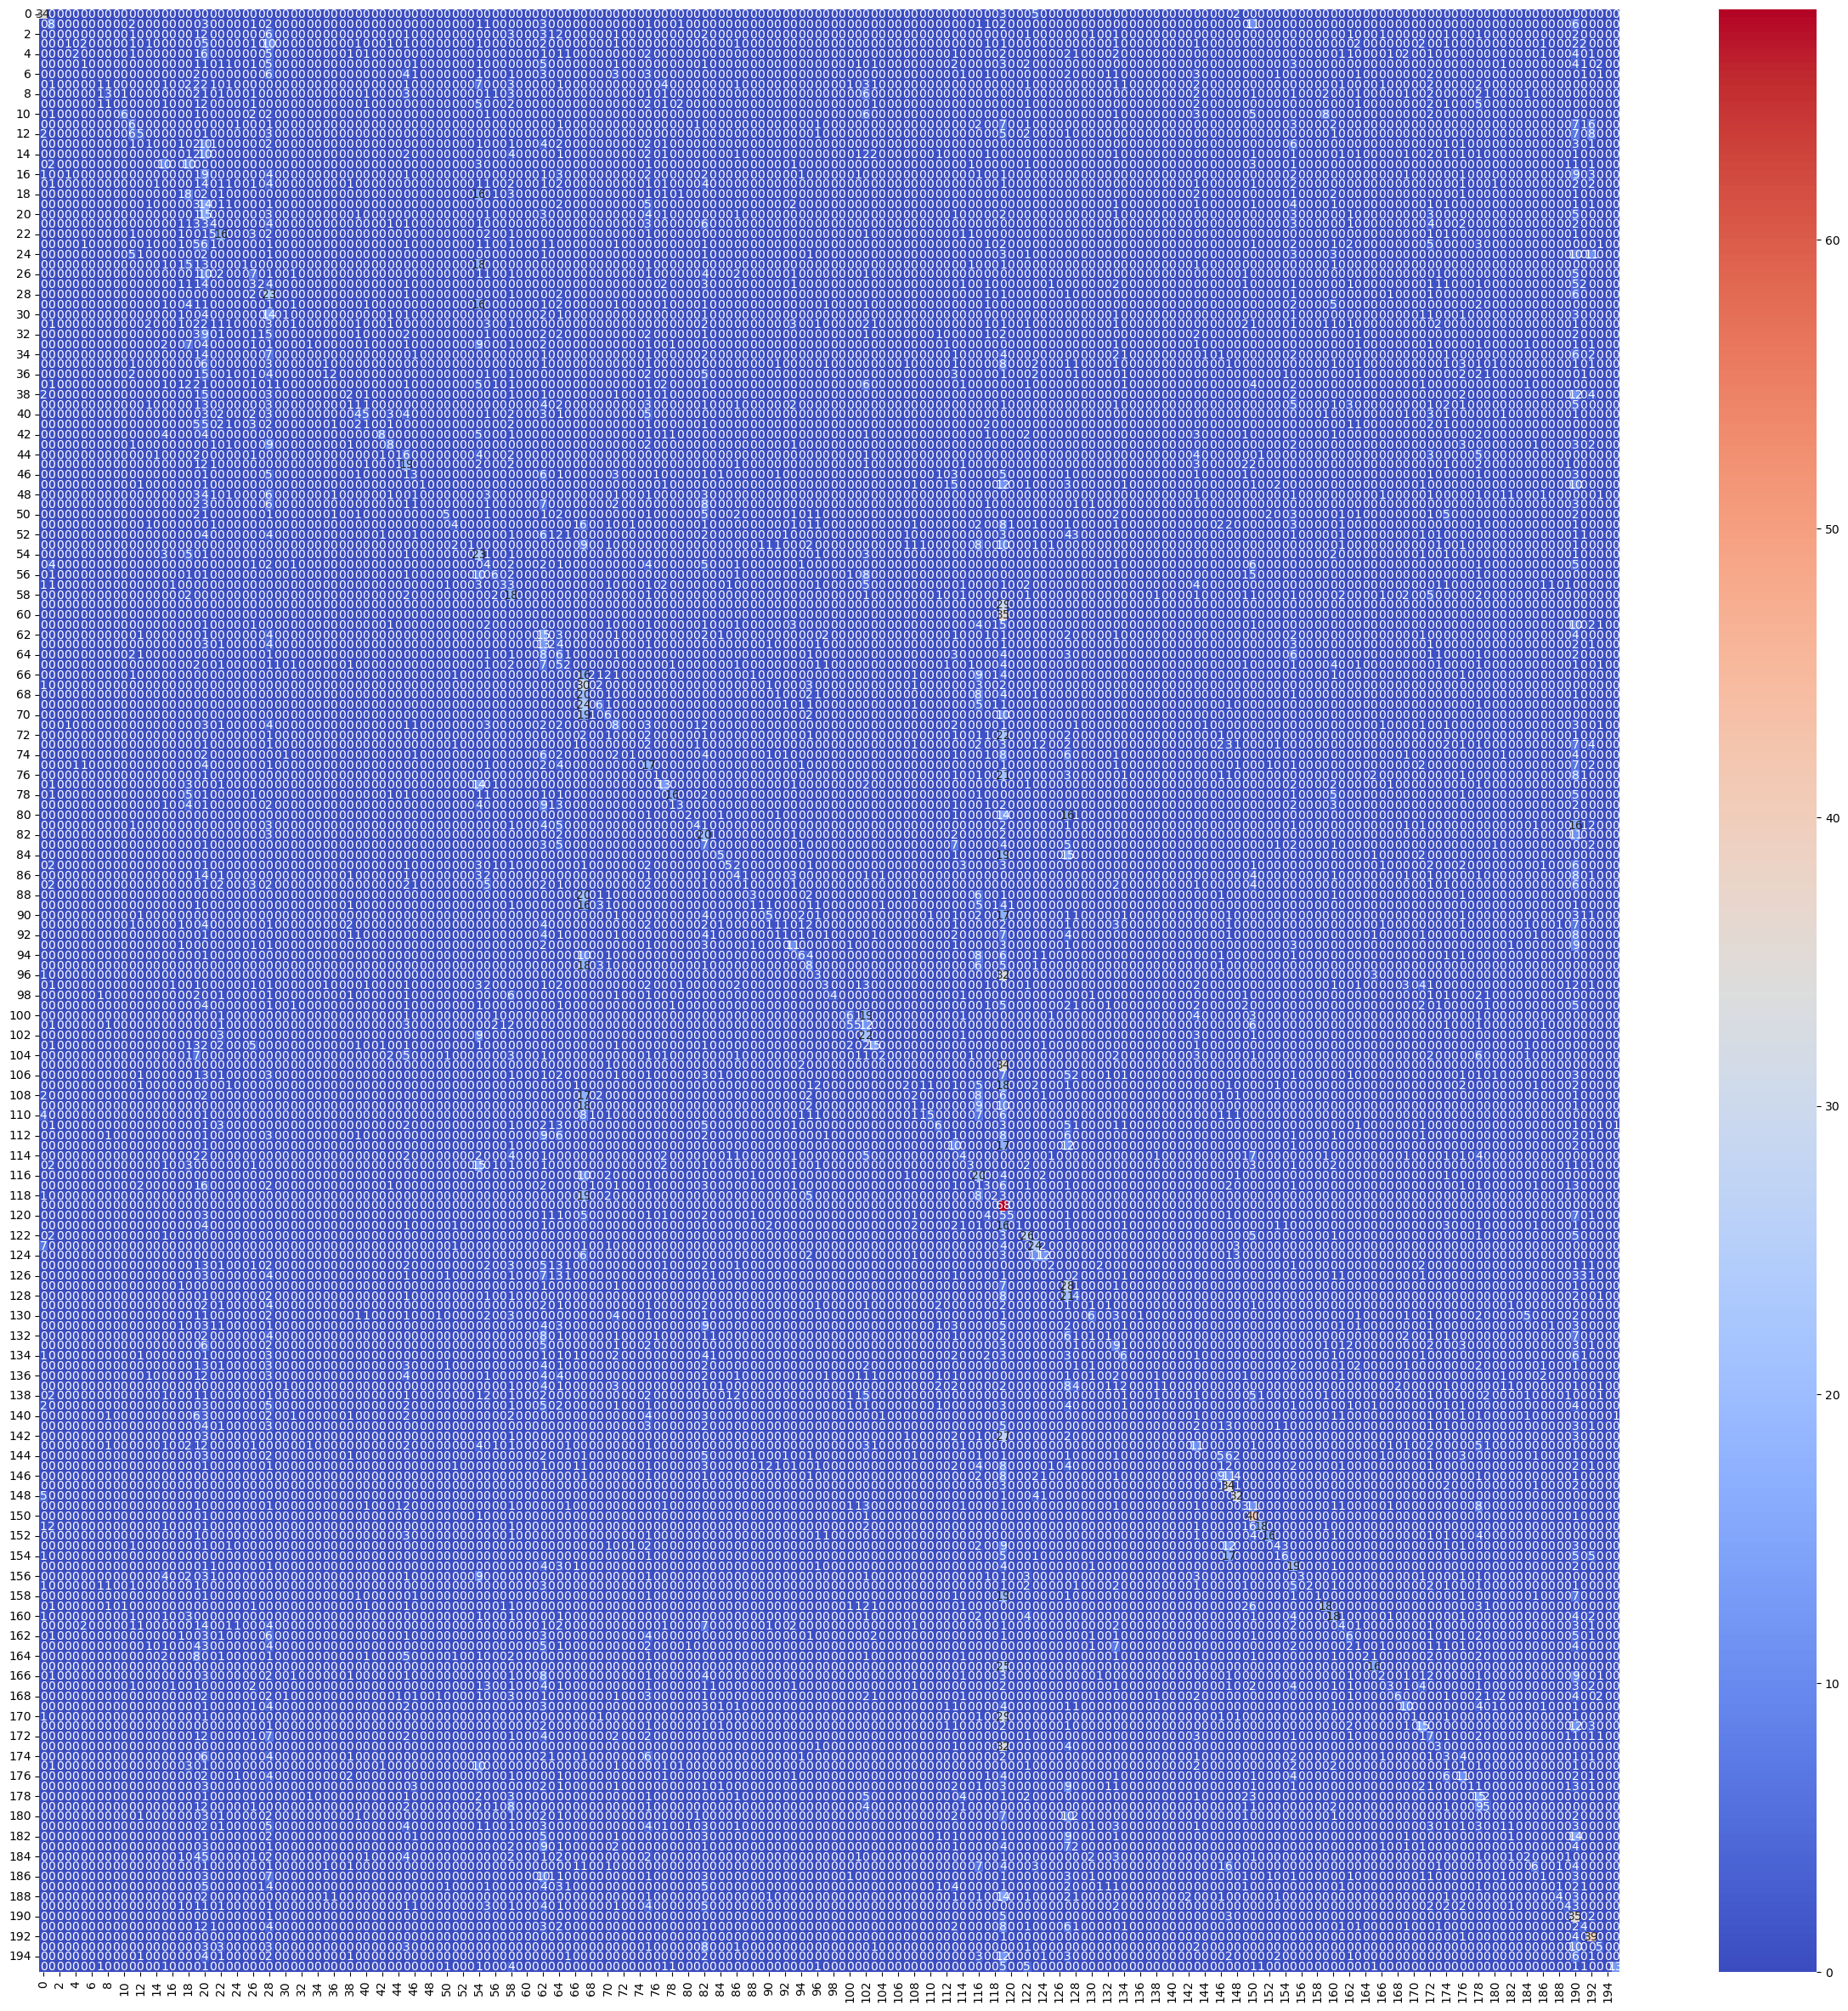

In [25]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm") 
plt.show()

In [26]:
# Flatten the confusion matrix DataFrame into a long format for filtering
cm_long = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
cm_long = cm_long.rename(columns={'index': 'Actual'})

# Filter for misclassifications (Actual != Predicted) where the count is greater than 10
misclassified = cm_long[(cm_long['Actual'] != cm_long['Predicted']) & (cm_long['Count'] > 10)]

# Sort for better visibility
misclassified = misclassified.sort_values(by='Count', ascending=False)

# Display or save
logger.info(misclassified)

[02/03/25 17:38:35] INFO     INFO -                                                   Actual  \    ]8;id=857839;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/3101041380.py\3101041380.py]8;;\:]8;id=302491;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/3101041380.py#12\12]8;;\
                             23384                         Chevrolet Express Van 2007                              
                             23429                       Ford E-Series Wagon Van 2012                              
                             23420                      Dodge Sprinter Cargo Van 2009                              
                             23497                     Ram C_V Cargo Van Minivan 2012                              
                             23383                   Chevrolet Express Cargo Van 2007                              
                             23494                       Nissan NV Passenger Van 2012                              
                             23466                            Isuzu Ascender SUV 2008                              
                             23489                    Mercedes-Benz Sprinter Van 2012                              
                             13201          Chevrolet Silverado 1500 Regular Cab 2012                              
                             23396                    Chevrolet Tahoe Hybrid SUV 2012                              
                             25020                         Honda Odyssey Minivan 2012                              
                             23400                            Chrysler Aspen SUV 2009                              
                             13220                         Dodge Dakota Club Cab 2007                              
                             13200      Chevrolet Silverado 1500 Hybrid Crew Cab 2012                              
                             13202        Chevrolet Silverado 2500HD Regular Cab 2012                              
                             23408                         Dodge Caravan Minivan 1997                              
                             13250                       GMC Canyon Extended Cab 2012                              
                             20092                Ferrari 458 Italia Convertible 2012                              
                             23482                             Mazda Tribute SUV 2011                              
                             13241                        Ford F-150 Regular Cab 2012                              
                             23431                        Ford Expedition EL SUV 2009                              
                             10609                      BMW 1 Series Convertible 2012                              
                             13227                Dodge Ram Pickup 3500 Quad Cab 2009                              
                             23437                         Ford Freestar Minivan 2007                              
                             23414                             Dodge Durango SUV 2007                              
                             28966                    Land Rover Range Rover SUV 2012                              
                             13240                        Ford F-150 Regular Cab 2007                              
                             24972             Chrysler Town and Country Minivan 2012                              
                             10602                           Audi S5 Convertible 2012                              
                             23445                          GMC Yukon Hybrid SUV 2012                              
                             13221                         Dodge Dakota Crew Cab 2010                              
                             13198  Chevrolet Silverado 1500 Classic Ex

In [27]:
logger.info(cr)

                    INFO     INFO -                                                                 ]8;id=338061;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/2671828649.py\2671828649.py]8;;\:]8;id=675618;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_9151/2671828649.py#1\1]8;;\
                             precision    recall  f1-score   support                                               
                                                                                                                   
                                                         AM General Hummer SUV 2000       0.49                     
                             0.77      0.60        44                                                              
                                                          Acura Integra Type R 2001       0.19                     
                             0.18      0.18        44                                                              
                                                                Acura RL Sedan 2012       0.00                     
                             0.00      0.00        32                                                              
                                                                Acura TL Sedan 2012       0.33                     
                             0.02      0.04        43                                                              
                                                               Acura TL Type-S 2008       0.67                     
                             0.05      0.09        42                                                              
                                                               Acura TSX Sedan 2012       0.14                     
                             0.03      0.04        40                                                              
                                                           Acura ZDX Hatchback 2012       0.00                     
                             0.00      0.00        39                                                              
                                           Aston Martin V8 Vantage Convertible 2012       0.17                     
                             0.02      0.04        45                                                              
                                                 Aston Martin V8 Vantage Coupe 2012       0.27                     
                             0.07      0.12        41                                                              
                                               Aston Martin Virage Convertible 2012       0.00                     
                             0.00      0.00        33                                                              
                                                     Aston Martin Virage Coupe 2012       0.75                     
                             0.16      0.26        38                                                              
                                                                Audi 100 Sedan 1994       0.16                     
                             0.15      0.15        40                                                              
                                                                Audi 100 Wagon 1994       0.28                     
                             0.12      0.17        42                                                              
                                                                 Audi A5 Coupe 2012       0.10                     
                             0.02      0.04        41                                                              
                                                                 Audi R8 Coupe 2012       0.00                     
                             0.00      0.00        43                   